In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

from summer2 import CompartmentalModel
from summer2.parameters import Parameter

In [2]:
def build_seir_model(
    config: dict,
) -> CompartmentalModel:
    
    # Model characteristics
    compartments = (
        "Susceptible", 
        "Pre-infectious", 
        "Infectious", 
        "Immune"
    )
    model = CompartmentalModel(
        times=(0., config["end_time"]),
        compartments=compartments,
        infectious_compartments=["Infectious"],
    )
    model.set_initial_population(
        distribution={
            "Susceptible": config["total_population"] * (1. - Parameter("prop_recovered")) - config["infectious_seed"], 
            "Infectious": config["infectious_seed"],
            "Immune": config["total_population"] * Parameter("prop_recovered"),
        }
    )
    
    # Transitions
    infectious_period = Parameter("infectious_period")
    model.add_infection_frequency_flow(
        name="infection", 
        contact_rate=Parameter("r0") / infectious_period,
        source="Susceptible",
        dest="Pre-infectious"
    )
    model.add_transition_flow(
        name="progression", 
        fractional_rate=1. / Parameter("latent_period"),
        source="Pre-infectious", 
        dest="Infectious"
    )
    model.add_transition_flow(
        name="recovery", 
        fractional_rate=1. / infectious_period,
        source="Infectious", 
        dest="Immune"
    )
    
    # Output
    model.request_output_for_flow(
        name="incidence", 
        flow_name="progression"
    )
    
    return model

In [3]:
model_config = {
    "total_population": 1e5,
    "infectious_seed": 1.,  # Not specified in text
    "end_time": 2e3,
}

parameters = {
    "r0": 13.,
    "latent_period": 8.,
    "infectious_period": 7.,
}

In [4]:
measles_model = build_seir_model(model_config)
measles_outputs = pd.DataFrame()
immune_props = (0., 0.9, 0.92, 0.923, 0.93, 0.95)
for immune_prop in immune_props:
    parameters.update({"prop_recovered": immune_prop})
    measles_model.run(parameters=parameters)
    measles_outputs[immune_prop] = measles_model.get_derived_outputs_df()["incidence"]

#### Panel a) - measles

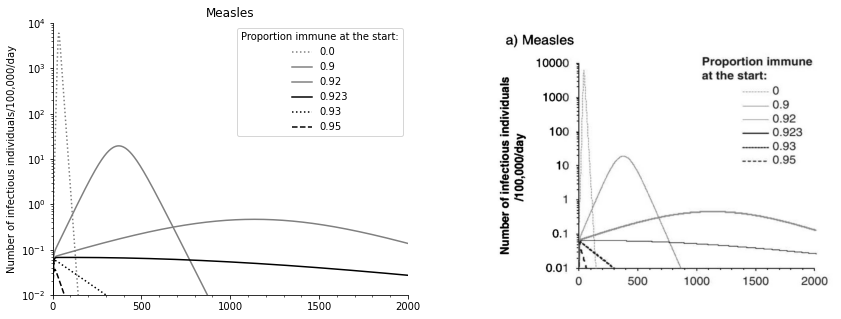

In [5]:
fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(14, 5))
line_styles = (":", "-", "-", "-", ":", "--")
colours = ("0.5", "0.5", "0.5", "0.", "0.", "0.")

for i_prop, prop in enumerate(immune_props):
    left_ax.plot(
        measles_model.times,
        measles_outputs[prop],
        label=prop,
        linestyle=line_styles[i_prop],
        color=colours[i_prop],
    )
left_ax.set_xlim(0., model_config["end_time"])
left_ax.set_xticks(range(0, 2500, 500))
left_ax.xaxis.set_minor_locator(AutoMinorLocator(5))
left_ax.set_yscale("log")
left_ax.set_ylim(0.01, 1e4)
left_ax.set_ylabel("Number of infectious individuals/100,000/day")
left_ax.legend(title="Proportion immune at the start:")
left_ax.set_title("Measles")
left_ax.spines.top.set_visible(False)
left_ax.spines.right.set_visible(False)

image = plt.imread("./figures/fig_4_5a.jpg")
right_ax.imshow(image, aspect="auto")
right_ax.axis("off");

In [6]:
parameters.update(
    {
        "r0": 2.,
        "latent_period": 2.,
        "infectious_period": 2.,
    }
)

flu_model = build_seir_model(model_config)
flu_outputs = pd.DataFrame()
immune_props = (0., 0.45, 0.49, 0.5, 0.51, 0.55)
for immune_prop in immune_props:
    parameters.update({"prop_recovered": immune_prop})
    flu_model.run(parameters=parameters)
    flu_outputs[immune_prop] = flu_model.get_derived_outputs_df()["incidence"]

#### Panel b) - influenza

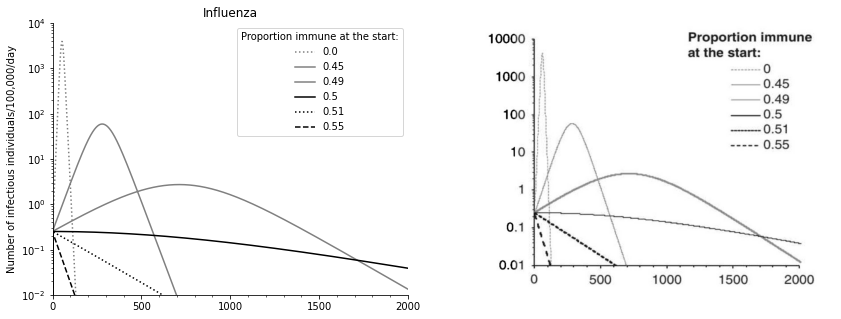

In [7]:
fig, (left_ax, right_ax) = plt.subplots(1, 2, figsize=(14, 5))

for i_prop, prop in enumerate(immune_props):
    left_ax.plot(
        flu_model.times, 
        flu_outputs[prop],
        label=prop,
        linestyle=line_styles[i_prop],
        color=colours[i_prop],
    )
left_ax.set_xlim(0., model_config["end_time"])
left_ax.set_xticks(range(0, 2500, 500))
left_ax.xaxis.set_minor_locator(AutoMinorLocator(5))
left_ax.set_yscale("log")
left_ax.set_ylim(0.01, 1e4)
left_ax.set_ylabel("Number of infectious individuals/100,000/day")
left_ax.legend(title="Proportion immune at the start:")
left_ax.set_title("Influenza")
left_ax.spines.top.set_visible(False)
left_ax.spines.right.set_visible(False)

image = plt.imread("./figures/fig_4_5b.jpg")
right_ax.imshow(image, aspect="auto")
right_ax.axis("off");